In [36]:
from os import listdir
from os.path import join
from numpy import mean
from numpy import std
from pandas import read_csv, concat, MultiIndex, DataFrame
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from numpy import array, vectorize, newaxis, arange, std, argsort
from sklearn.metrics import confusion_matrix
from seaborn import pairplot, heatmap
from matplotlib.pylab import figure, savefig, subplots, xticks, yticks, boxplot, show
from mlxtend.classifier import StackingClassifier

import warnings
warnings.filterwarnings('ignore')

def to_seconds(time_str):
    time_list = time_str.split(':')
    return float(time_list[0])*60+float(time_list[1])

class NFL_data:
    def __init__(self, file_name, dir_of_files):
        self.dir_of_files = dir_of_files
        part_of_team = file_name.replace(dir_of_files,'').rstrip('.csv')
        self.file_dict = {part_of_team:file_name}
        self.build_data_frame(part_of_team)
        
        self.link_matchups = {}
               
    def build_data_frame(self,part_of_team):
        nfl_df = read_csv(join(self.dir_of_files,self.file_dict[part_of_team]),header=[0])
        nfl_df.sort_values('Team',inplace=True)
        nfl_df.reset_index(drop=True,inplace=True)
        self.nfl_df_dict = {part_of_team:nfl_df}
        self.teams = list(nfl_df['Team'])
        
    def add_to_data_frame(self,file_name):
        part_of_team = file_name.rstrip('.csv')
        self.file_dict[part_of_team] = file_name
        nfl_df = read_csv(join(self.dir_of_files,self.file_dict[part_of_team]),header=[0])
        nfl_df.sort_values('Team',inplace=True)
        nfl_df.reset_index(drop=True,inplace=True)
        self.nfl_df_dict[part_of_team] = nfl_df
    
    def preprocessing(self):
        for key in self.nfl_df_dict.keys():
            for col in self.nfl_df_dict[key].columns:
                if col == 'Team':
                    continue
                filtered_percentages = self.nfl_df_dict[key][col].astype(str).str.contains('%')
                for i in range(len(filtered_percentages)):
                    if filtered_percentages.iloc[i]:
                        self.nfl_df_dict[key][col].iloc[i] = float(self.nfl_df_dict[key][col].iloc[i].replace('%','')) / 100.0
    
                if self.nfl_df_dict[key][col].isnull().values.any():
                    self.nfl_df_dict[key][col] = self.nfl_df_dict[key][col].fillna(0)
        
            if 'Time/Drive' in self.nfl_df_dict[key].columns:
                self.nfl_df_dict[key]['Time/Drive'] = vectorize(to_seconds)(self.nfl_df_dict[key]['Time/Drive'])
            if 'OppTime/Drive' in self.nfl_df_dict[key].columns:
                self.nfl_df_dict[key]['OppTime/Drive'] = vectorize(to_seconds)(self.nfl_df_dict[key]['OppTime/Drive'])
    
    def remove_corr(self,threshold=0.5):
        self.pearson_pre_season_corr_feaures_dict = {}
        self.pearson_pre_season_corr = {}
        for key in self.nfl_df_dict.keys():
            self.pearson_pre_season_corr_feaures_dict[key] = set() 
            self.pearson_pre_season_corr[key] = self.nfl_df_dict[key][self.nfl_df_dict[key].columns[1:]].corr(method='pearson')
            
            for i in range(len(self.pearson_pre_season_corr[key].columns)):
                for j in range(i):
                    if abs(self.pearson_pre_season_corr[key].iloc[i, j]) > threshold:
                        colname = self.pearson_pre_season_corr[key].columns[i]
                        self.pearson_pre_season_corr_feaures_dict[key].add(colname)
                    
            
            self.nfl_df_dict[key].drop(labels=self.pearson_pre_season_corr_feaures_dict[key], axis=1, inplace=True)
            
    
    def pair_plots(self):
        for key in self.game_df_dict.keys():
            print(self.game_df_dict[key].shape)
            self.game_df_dict[key].reset_index(drop=True,inplace=True)
            print(self.game_df_dict[key].columns)
            fig,ax = subplots(figsize=(10,10))
            pairplot(self.game_df_dict[key],hue='Winner',vars=self.game_df_dict[key][self.game_df_dict[key].columns[1:]])
            xticks(fontsize="10",rotation=90)
            yticks(rotation=90, fontsize="10", va="center")
            savefig('D:NFL data for data mining\pics\pairplot_%s.png'%key)
            
            print('Saved D:NFL data for data mining\pics\pairplot_%s.png'%key)
    
    def cc_heatmap(self):
        self.pearson_corr = {}
        for key in self.nfl_df_dict.keys():
            fig,ax = subplots(figsize=(10,10))
            self.pearson_corr[key] = self.nfl_df_dict[key].corr(method='pearson')
            xticklabels = self.pearson_corr[key].columns
            yticklabels = xticklabels
            try:
                heatmap(self.pearson_corr[key],cmap='Reds',linecolor='k',xticklabels=xticklabels,yticklabels=yticklabels,ax=ax,linewidth=1.0)#,annot_kws={"size": 60},fmt='0.2f')
            except:
                pass
            xticks(fontsize="10",rotation=90)
            yticks(arange(len(yticklabels))+0.5,yticklabels, rotation=0, fontsize="10", va="center")
            savefig('D:NFL data for data mining\pics\heatmap_%s.png'%key,dpi=300,bbox_inches='tight')
    
    def create_NFL_season_data(self,df_schedule):
        self.game_df_dict = {}
        schedule_cols = ['Home','Away','Winner','Tie']
        df_schedule = df_schedule[schedule_cols]
        df_schedule.dropna(inplace=True,axis=0)
        df_schedule = df_schedule[df_schedule['Tie'] == False]
        game_set = set()
                
        for i in range(len(df_schedule)):
            home_team = df_schedule['Home'].iloc[i]
            away_team = df_schedule['Away'].iloc[i]
            winner = df_schedule['Winner'].iloc[i]

            if (home_team,away_team) in game_set or (away_team,home_team) in game_set:
                continue
                
            game_set.add((home_team,away_team))
            
            for key in self.nfl_df_dict.keys():
                home_team_row = self.nfl_df_dict[key].loc[self.nfl_df_dict[key]['Team']==home_team]
                away_team_row = self.nfl_df_dict[key].loc[self.nfl_df_dict[key]['Team']==away_team]
                
                home_team_row.dropna(inplace=True)
                home_team_row.drop(columns='Team',inplace=True)
                away_team_row.dropna(inplace=True)
                away_team_row.drop(columns='Team',inplace=True)
                home_team_row_name = []
                away_team_row_name = []
                for i in range(len(home_team_row.columns)):
                    home_team_row_name.append('Home ' + key + ' ' + home_team_row.columns[i])
                for i in range(len(away_team_row.columns)):
                    away_team_row_name.append('Away ' + key + ' ' + away_team_row.columns[i])
                
                home_team_row.columns = home_team_row_name
                away_team_row.columns = away_team_row_name
                
                home_team_row.reset_index(drop=True,inplace=True)
                away_team_row.reset_index(drop=True,inplace=True)
                
                df_tmp = concat([home_team_row,away_team_row],axis=1)
                
                if key not in self.game_df_dict.keys():
                    self.game_df_dict[key] = df_tmp
                else:
                    self.game_df_dict[key] = concat([self.game_df_dict[key],df_tmp])

        df_schedule['Winner'][df_schedule['Winner']==df_schedule['Home']] = 0
        df_schedule['Winner'][df_schedule['Winner']==df_schedule['Away']]= 1
        
        for key in self.game_df_dict.keys():
            self.game_df_dict[key].reset_index(drop=True,inplace=True)
            self.game_df_dict[key] = concat([df_schedule['Home'],df_schedule['Away'],df_schedule['Winner'],self.game_df_dict[key]],axis=1)

    def concat_schedules(self,nfl_data2):
        self.dir_of_files = [self.dir_of_files, nfl_data2.dir_of_files]
        self.file_dict = [self.file_dict,nfl_data2.file_dict]
        
        for key in nfl_data2.nfl_df_dict.keys():
            self.nfl_df_dict[key] = nfl_data2.nfl_df_dict[key]
            
        for key in self.game_df_dict.keys():
            self.game_df_dict[key] = concat([self.game_df_dict[key],nfl_data2.game_df_dict[key+'2021']])
            
            
    def combine_game_data(self):
        count = 0
        self.model_game_data = DataFrame()
        for key in self.game_df_dict.keys():
            self.game_df_dict[key].fillna(0,inplace=True)
            X = self.game_df_dict[key].drop(columns=['Home','Away','Winner'])
            print(key)
            X = X.astype('float')
            self.model_game_data = concat([self.model_game_data,X],axis=1)
            if count == 0:
                y_test = self.game_df_dict[key]['Winner']
                self.y = y_test.astype('int')
                count += 1
        
        self.ss = StandardScaler()
        self.ss.fit_transform(self.model_game_data)
            
    def forest_feature_selection(self,top_features):
        forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
        forest.fit(self.model_game_data, self.y)

        importances = forest.feature_importances_
        std2 = std(
            [tree.feature_importances_ for tree in forest.estimators_],
            axis=0
        )
        indices = argsort(importances)[::-1]
        indices = indices[:top_features]

        self.forest_indices = indices
        for i in indices:
            print(self.model_game_data.columns[i])
        self.forest_importances = importances
        
        print('Top features:')
        for f in range(len(indices)):
            print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))
            
        self.model_game_data = self.model_game_data.iloc[indices]
    
    def get_models(self):
        self.models = dict()
        
        names = [
            "Logistic Regression",
            "Nearest Neighbors",
            "Linear SVM",
            "RBF SVM",
            "Gaussian Process",
            "Decision Tree",
            "Random Forest",
            "Neural Net",
            "AdaBoost",
            "Naive Bayes",
            "QDA",
        ]
        
        classifiers = [
            LogisticRegression(C=0.025),
            KNeighborsClassifier(2),
            SVC(kernel="linear", C=0.025),
            SVC(gamma=2, C=1),
            GaussianProcessClassifier(1.0 * RBF(1.0)),
            DecisionTreeClassifier(max_depth=3),
            RandomForestClassifier(max_depth=3, n_estimators=5, max_features=1),
            MLPClassifier(alpha=1, max_iter=1000),
            AdaBoostClassifier(),
            GaussianNB(),
            QuadraticDiscriminantAnalysis(),
        ]
        
        for name,clf in zip(names,classifiers):
            self.models[name] = {}
            for i in arange(5,160,5):
                steps = [('svd', TruncatedSVD(n_components=i)), (name, clf)]
                self.models[name][str(i)] = Pipeline(steps=steps)

    def evaluate_model(self,model, X, y):
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        return scores
    
    def matchup_binary_classifiers(self):
        self.get_models()
        self.results = {}
        for name, model in self.models.items():
            self.results[name] = []
            for m in model:
                scores = self.evaluate_model(model[m], self.model_game_data, self.y)
                self.results[name].append(scores)
                print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
         
            boxplot(self.results[name], labels=model.keys(), showmeans=True)
            xticks(rotation=90)
            savefig('D:NFL data for data mining\pics\%s_model_evalution.png'%name)
            show()
            
    def binary_classifiers(self):
        
        names = [
            "LogisticRegression",
            "Nearest Neighbors",
            "Linear SVM",
            "RBF SVM",
            "Gaussian Process",
            "Decision Tree",
            "Random Forest",
            "Neural Net",
            "AdaBoost",
            "Naive Bayes",
            "QDA",
        ]
        
        classifiers = [
            LogisticRegression(),
            KNeighborsClassifier(3),
            SVC(kernel="linear", C=0.025),
            SVC(gamma=2, C=1),
            GaussianProcessClassifier(1.0 * RBF(1.0)),
            DecisionTreeClassifier(max_depth=5),
            RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
            MLPClassifier(alpha=1, max_iter=1000),
            AdaBoostClassifier(),
            GaussianNB(),
            QuadraticDiscriminantAnalysis(),
        ]
        
        self.model_game_data.reset_index(drop=True,inplace=True)
        self.y.reset_index(drop=True,inplace=True)
        
        x_train, x_test, y_train, y_test = train_test_split(self.model_game_data, self.y, test_size=0.2)
        self.train_indices = x_train.index
        self.test_indices = x_test.index
        self.results = {}
        self.fit_models = {}
        for name, clf in zip(names, classifiers):
            clf.fit(x_train, y_train)
            self.fit_models[name] = clf
            score = clf.score(x_test, y_test)
            self.results[name+'_train_test'] = score
            print(name+': %f'%score)      

In [37]:

#Setting up data from files
directory = 'D:/NFL data for data mining/Modifed CSV - LOOK/2020/'
file_list = listdir(directory)
nfl_data = NFL_data(file_list[0],directory)

df_2020_schedule = read_csv('D:NFL data for data mining/Data csv/2020/2020_schedule_win_lose.csv',header=[0])
df_2020_schedule.reset_index(drop=True,inplace=True)

count = 0
for file in file_list[1:]:
    print(file)
    nfl_data.add_to_data_frame(file)

directory = 'D:/NFL data for data mining/Modifed CSV - LOOK/2021/'
file_list = listdir(directory)
nfl_data2 = NFL_data(file_list[0],directory)

df_2021_schedule = read_csv('D:NFL data for data mining/Data csv/2021/2021_schedule_win_lose.csv',header=[0])
df_2021_schedule.reset_index(drop=True,inplace=True)

count = 0
for file in file_list:
    print(file)
    nfl_data2.add_to_data_frame(file)

    
#Run functions in class on data
nfl_data.preprocessing()
nfl_data.remove_corr()
nfl_data.create_NFL_season_data(df_2020_schedule)

nfl_data2.preprocessing()
nfl_data2.remove_corr()
nfl_data2.create_NFL_season_data(df_2021_schedule)
nfl_data.concat_schedules(nfl_data2)

nfl_data.combine_game_data()


#nfl_data.forest_feature_selection(15)

DefenseDiscipline.csv
DefenseDrive.csv
DefenseO-Line_QBApproach.csv
DefenseTackling.csv
DefenseTurnover.csv
Kicker.csv
Kickoff.csv
KickPuntReturn.csv
OffenseConversions.csv
OffenseDiscipline.csv
OffenseDrives.csv
OffenseQBPerformance.csv
OffenseScoring.csv
OffenseTurnover.csv
PassingDefenseComplete.csv
PassingOffenseComplete.csv
Punter.csv
RushingDefenseComplete.csv
RushingOffenseComplete.csv
DefenseConversion2021.csv
DefenseDiscipline2021.csv
DefenseDrive2021.csv
DefenseO-Line_QBApproach2021.csv
DefenseTackling2021.csv
DefenseTurnover2021.csv
Kicker2021.csv
Kickoff2021.csv
KickPuntReturn2021.csv
OffenseConversion2021.csv
OffenseDiscipline2021.csv
OffenseDrive2021.csv
OffenseQBPerformance2021.csv
OffenseScoring2021.csv
OffenseTurnover2021.csv
PassingDefenseComplete2021.csv
PassingOffenseComplete2021.csv
Punter2021.csv
RushingDefenseComplete2021.csv
RushingOffenseComplete2021.csv
DefenseConversion
DefenseDiscipline
DefenseDrive
DefenseO-Line_QBApproach
DefenseTackling
DefenseTurnover
Ki

In [38]:
nfl_data.binary_classifiers()

LogisticRegression: 0.505495
Nearest Neighbors: 0.505495
Linear SVM: 0.494505
RBF SVM: 0.483516
Gaussian Process: 0.439560
Decision Tree: 0.483516
Random Forest: 0.450549
Neural Net: 0.538462
AdaBoost: 0.494505
Naive Bayes: 0.461538
QDA: 0.527473


>Logistic Regression 0.500 (0.057)
>Logistic Regression 0.488 (0.035)
>Logistic Regression 0.509 (0.041)
>Logistic Regression 0.526 (0.039)
>Logistic Regression 0.506 (0.053)
>Logistic Regression 0.500 (0.043)
>Logistic Regression 0.489 (0.041)
>Logistic Regression 0.500 (0.049)
>Logistic Regression 0.497 (0.044)
>Logistic Regression 0.502 (0.042)
>Logistic Regression 0.497 (0.044)
>Logistic Regression 0.494 (0.043)
>Logistic Regression 0.494 (0.042)
>Logistic Regression 0.490 (0.042)
>Logistic Regression 0.490 (0.042)
>Logistic Regression 0.485 (0.041)
>Logistic Regression 0.487 (0.041)
>Logistic Regression 0.486 (0.042)
>Logistic Regression 0.487 (0.042)
>Logistic Regression 0.485 (0.041)
>Logistic Regression 0.486 (0.042)
>Logistic Regression 0.486 (0.041)
>Logistic Regression 0.488 (0.041)
>Logistic Regression 0.483 (0.041)
>Logistic Regression 0.488 (0.041)
>Logistic Regression 0.488 (0.042)
>Logistic Regression 0.489 (0.041)
>Logistic Regression 0.489 (0.042)
>Logistic Regression

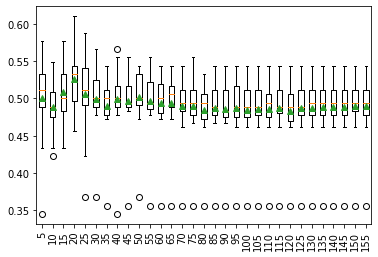

>Nearest Neighbors 0.487 (0.040)
>Nearest Neighbors 0.488 (0.038)
>Nearest Neighbors 0.498 (0.037)
>Nearest Neighbors 0.490 (0.035)
>Nearest Neighbors 0.479 (0.027)
>Nearest Neighbors 0.469 (0.031)
>Nearest Neighbors 0.468 (0.037)
>Nearest Neighbors 0.473 (0.037)
>Nearest Neighbors 0.475 (0.035)
>Nearest Neighbors 0.473 (0.037)
>Nearest Neighbors 0.471 (0.033)
>Nearest Neighbors 0.476 (0.035)
>Nearest Neighbors 0.477 (0.035)
>Nearest Neighbors 0.477 (0.038)
>Nearest Neighbors 0.475 (0.037)
>Nearest Neighbors 0.475 (0.037)
>Nearest Neighbors 0.475 (0.037)
>Nearest Neighbors 0.475 (0.037)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest Neighbors 0.474 (0.035)
>Nearest N

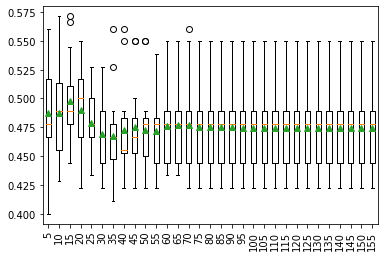

>Linear SVM 0.480 (0.038)
>Linear SVM 0.486 (0.033)
>Linear SVM 0.503 (0.046)
>Linear SVM 0.527 (0.035)
>Linear SVM 0.503 (0.043)
>Linear SVM 0.482 (0.046)
>Linear SVM 0.489 (0.035)
>Linear SVM 0.488 (0.032)
>Linear SVM 0.489 (0.031)
>Linear SVM 0.484 (0.037)
>Linear SVM 0.488 (0.039)
>Linear SVM 0.487 (0.049)
>Linear SVM 0.490 (0.044)
>Linear SVM 0.487 (0.042)
>Linear SVM 0.485 (0.042)
>Linear SVM 0.489 (0.043)
>Linear SVM 0.487 (0.042)
>Linear SVM 0.489 (0.037)
>Linear SVM 0.489 (0.038)
>Linear SVM 0.487 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)
>Linear SVM 0.486 (0.039)


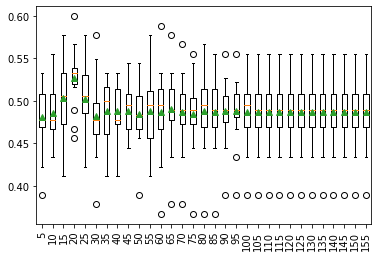

>RBF SVM 0.483 (0.037)
>RBF SVM 0.479 (0.025)
>RBF SVM 0.469 (0.018)
>RBF SVM 0.470 (0.014)
>RBF SVM 0.469 (0.015)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.469 (0.015)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.471 (0.017)
>RBF SVM 0.471 (0.017)
>RBF SVM 0.471 (0.017)
>RBF SVM 0.471 (0.017)
>RBF SVM 0.471 (0.017)
>RBF SVM 0.471 (0.017)
>RBF SVM 0.471 (0.017)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.469 (0.015)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.469 (0.015)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)
>RBF SVM 0.470 (0.016)


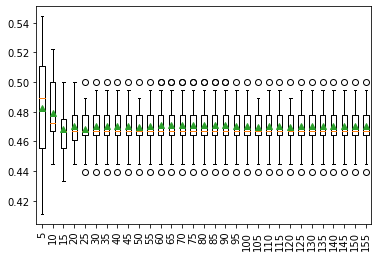

>Gaussian Process 0.480 (0.039)
>Gaussian Process 0.483 (0.038)
>Gaussian Process 0.466 (0.037)
>Gaussian Process 0.452 (0.028)
>Gaussian Process 0.448 (0.029)
>Gaussian Process 0.443 (0.034)
>Gaussian Process 0.441 (0.034)
>Gaussian Process 0.440 (0.036)
>Gaussian Process 0.438 (0.031)
>Gaussian Process 0.441 (0.029)
>Gaussian Process 0.447 (0.032)
>Gaussian Process 0.452 (0.034)
>Gaussian Process 0.452 (0.033)
>Gaussian Process 0.452 (0.032)
>Gaussian Process 0.450 (0.032)
>Gaussian Process 0.450 (0.032)
>Gaussian Process 0.451 (0.031)
>Gaussian Process 0.451 (0.031)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)
>Gaussian Process 0.450 (0.033)


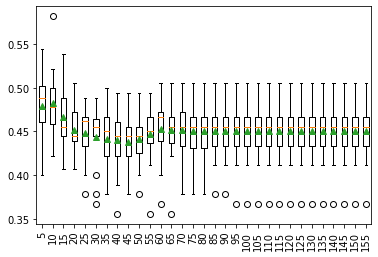

>Decision Tree 0.494 (0.025)
>Decision Tree 0.489 (0.049)
>Decision Tree 0.489 (0.041)
>Decision Tree 0.494 (0.043)
>Decision Tree 0.491 (0.043)
>Decision Tree 0.506 (0.029)
>Decision Tree 0.503 (0.038)
>Decision Tree 0.495 (0.037)
>Decision Tree 0.500 (0.022)
>Decision Tree 0.511 (0.024)
>Decision Tree 0.497 (0.031)
>Decision Tree 0.492 (0.036)
>Decision Tree 0.482 (0.036)
>Decision Tree 0.496 (0.038)
>Decision Tree 0.488 (0.034)
>Decision Tree 0.505 (0.046)
>Decision Tree 0.491 (0.031)
>Decision Tree 0.494 (0.029)
>Decision Tree 0.500 (0.029)
>Decision Tree 0.496 (0.032)
>Decision Tree 0.498 (0.028)
>Decision Tree 0.505 (0.026)
>Decision Tree 0.498 (0.024)
>Decision Tree 0.503 (0.025)
>Decision Tree 0.498 (0.025)
>Decision Tree 0.494 (0.030)
>Decision Tree 0.495 (0.034)
>Decision Tree 0.491 (0.030)
>Decision Tree 0.500 (0.028)
>Decision Tree 0.499 (0.030)
>Decision Tree 0.497 (0.033)


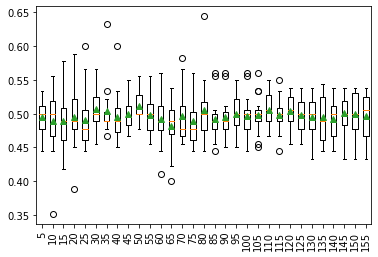

>Random Forest 0.491 (0.051)
>Random Forest 0.521 (0.043)
>Random Forest 0.479 (0.036)
>Random Forest 0.495 (0.042)
>Random Forest 0.512 (0.045)
>Random Forest 0.494 (0.036)
>Random Forest 0.473 (0.051)
>Random Forest 0.497 (0.037)
>Random Forest 0.497 (0.031)
>Random Forest 0.494 (0.063)
>Random Forest 0.486 (0.051)
>Random Forest 0.473 (0.042)
>Random Forest 0.499 (0.042)
>Random Forest 0.484 (0.039)
>Random Forest 0.494 (0.044)
>Random Forest 0.482 (0.042)
>Random Forest 0.501 (0.048)
>Random Forest 0.481 (0.056)
>Random Forest 0.474 (0.046)
>Random Forest 0.489 (0.053)
>Random Forest 0.509 (0.046)
>Random Forest 0.480 (0.040)
>Random Forest 0.489 (0.042)
>Random Forest 0.493 (0.044)
>Random Forest 0.483 (0.045)
>Random Forest 0.487 (0.058)
>Random Forest 0.480 (0.057)
>Random Forest 0.497 (0.037)
>Random Forest 0.485 (0.071)
>Random Forest 0.494 (0.060)
>Random Forest 0.495 (0.049)


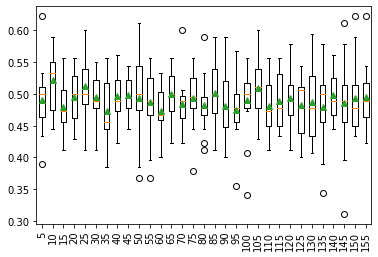

>Neural Net 0.498 (0.054)
>Neural Net 0.482 (0.040)
>Neural Net 0.497 (0.042)
>Neural Net 0.481 (0.050)
>Neural Net 0.461 (0.044)
>Neural Net 0.473 (0.043)
>Neural Net 0.457 (0.044)
>Neural Net 0.449 (0.037)
>Neural Net 0.442 (0.043)
>Neural Net 0.484 (0.038)
>Neural Net 0.443 (0.031)
>Neural Net 0.467 (0.050)
>Neural Net 0.466 (0.043)
>Neural Net 0.446 (0.033)
>Neural Net 0.459 (0.041)
>Neural Net 0.466 (0.041)
>Neural Net 0.474 (0.035)
>Neural Net 0.462 (0.039)
>Neural Net 0.454 (0.044)
>Neural Net 0.466 (0.049)
>Neural Net 0.460 (0.050)
>Neural Net 0.462 (0.033)
>Neural Net 0.457 (0.034)
>Neural Net 0.461 (0.044)
>Neural Net 0.465 (0.052)
>Neural Net 0.474 (0.034)
>Neural Net 0.461 (0.038)
>Neural Net 0.460 (0.041)
>Neural Net 0.472 (0.021)
>Neural Net 0.465 (0.047)
>Neural Net 0.452 (0.034)


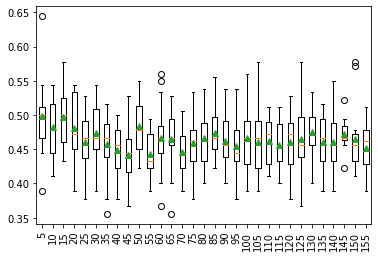

>AdaBoost 0.502 (0.041)
>AdaBoost 0.483 (0.034)
>AdaBoost 0.486 (0.050)
>AdaBoost 0.480 (0.050)
>AdaBoost 0.480 (0.044)
>AdaBoost 0.469 (0.040)
>AdaBoost 0.473 (0.054)
>AdaBoost 0.481 (0.046)
>AdaBoost 0.503 (0.056)
>AdaBoost 0.492 (0.040)
>AdaBoost 0.503 (0.049)
>AdaBoost 0.487 (0.035)
>AdaBoost 0.494 (0.043)
>AdaBoost 0.471 (0.041)
>AdaBoost 0.489 (0.039)
>AdaBoost 0.483 (0.039)
>AdaBoost 0.489 (0.044)
>AdaBoost 0.499 (0.037)
>AdaBoost 0.502 (0.054)
>AdaBoost 0.503 (0.046)
>AdaBoost 0.514 (0.059)
>AdaBoost 0.494 (0.032)
>AdaBoost 0.499 (0.031)
>AdaBoost 0.497 (0.031)
>AdaBoost 0.488 (0.040)
>AdaBoost 0.477 (0.043)
>AdaBoost 0.477 (0.043)
>AdaBoost 0.477 (0.043)
>AdaBoost 0.477 (0.043)
>AdaBoost 0.477 (0.043)
>AdaBoost 0.477 (0.043)


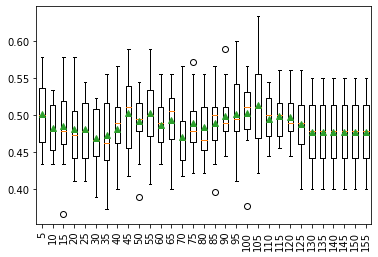

>Naive Bayes 0.492 (0.049)
>Naive Bayes 0.490 (0.038)
>Naive Bayes 0.477 (0.051)
>Naive Bayes 0.482 (0.047)
>Naive Bayes 0.480 (0.045)
>Naive Bayes 0.471 (0.038)
>Naive Bayes 0.473 (0.049)
>Naive Bayes 0.480 (0.042)
>Naive Bayes 0.470 (0.047)
>Naive Bayes 0.471 (0.036)
>Naive Bayes 0.485 (0.044)
>Naive Bayes 0.483 (0.034)
>Naive Bayes 0.505 (0.046)
>Naive Bayes 0.492 (0.050)
>Naive Bayes 0.491 (0.051)
>Naive Bayes 0.487 (0.051)
>Naive Bayes 0.489 (0.043)
>Naive Bayes 0.510 (0.056)
>Naive Bayes 0.504 (0.053)
>Naive Bayes 0.499 (0.053)
>Naive Bayes 0.490 (0.044)
>Naive Bayes 0.495 (0.044)
>Naive Bayes 0.486 (0.040)
>Naive Bayes 0.491 (0.044)
>Naive Bayes 0.484 (0.041)
>Naive Bayes 0.486 (0.042)
>Naive Bayes 0.486 (0.042)
>Naive Bayes 0.486 (0.042)
>Naive Bayes 0.486 (0.042)
>Naive Bayes 0.486 (0.042)
>Naive Bayes 0.486 (0.042)


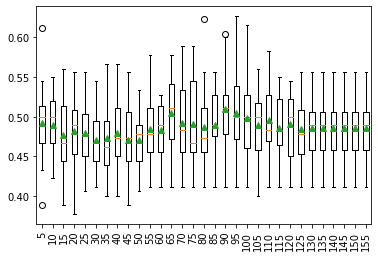

>QDA 0.487 (0.052)
>QDA 0.497 (0.035)
>QDA 0.476 (0.039)
>QDA 0.472 (0.047)
>QDA 0.477 (0.046)
>QDA 0.457 (0.054)
>QDA 0.462 (0.058)
>QDA 0.476 (0.050)
>QDA 0.478 (0.047)
>QDA 0.473 (0.049)
>QDA 0.468 (0.049)
>QDA 0.481 (0.053)
>QDA 0.473 (0.063)
>QDA 0.469 (0.063)
>QDA 0.463 (0.061)
>QDA 0.457 (0.057)
>QDA 0.469 (0.050)
>QDA 0.474 (0.061)
>QDA 0.480 (0.053)
>QDA 0.476 (0.050)
>QDA 0.477 (0.051)
>QDA 0.482 (0.051)
>QDA 0.480 (0.046)
>QDA 0.497 (0.036)
>QDA 0.492 (0.037)
>QDA 0.494 (0.034)
>QDA 0.494 (0.034)
>QDA 0.494 (0.034)
>QDA 0.494 (0.034)
>QDA 0.494 (0.034)
>QDA 0.494 (0.034)


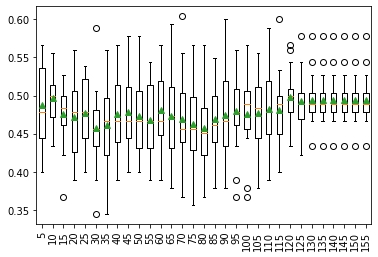

In [40]:
nfl_data.matchup_binary_classifiers()